In [1]:
from os import listdir
from numpy import zeros, mean, asarray, expand_dims
from mrcnn.config import Config
from mrcnn.model import MaskRCNN, mold_image, load_image_gt
from mrcnn.utils import Dataset, compute_ap
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
class PersonDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "person")
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        
        for filename in listdir(images_dir):
     
            image_id = filename[:-4]
            num = image_id[7:]
            if(filename.find('person')==-1):  #one of the image had a negative bounding box. Just skipping it for now
                continue
           
            if is_train and int(num) >= 197:  #images after 197 are test images
                continue
            
            if not is_train and int(num) < 197:   #images before 197 are test images
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.txt'
    
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
            

    
    def extract_boxes(self, filename):
      
        f = open(filename)
        text = f.read()
        text = text.split('\n')
        channels = text[3][-1]
        height = text[3][-7:-4]
        width = text[3][-13:-10]
        height = int(height)
        width = int(width)

        boxes = list()
        for line in text:
            if(line.find("Bounding box") != -1):
                index = line.find(':')
                labels = line[index+1:]

                labels = labels.strip() 
                index = labels.find('-')
                min_labels = labels[:index-1]
                max_labels = labels[index+2:]

                comma = min_labels.find(',')
                xmin = min_labels[1:comma]
                ymin = min_labels[comma+2:-1]

                comma = max_labels.find(',')
                xmax = max_labels[1:comma]
                ymax = max_labels[comma+2:-1]

                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                coord = [xmin, ymin, xmax, ymax]
                boxes.append(coord)
        return boxes, width, height


    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('person'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = PersonDataset()
train_set.load_dataset('person', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = PersonDataset()
test_set.load_dataset('person', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 135
Test: 32


In [3]:
from matplotlib.patches import Rectangle
def plot_predicted(image,yhat):
    pyplot.imshow(image)
    pyplot.title('Predicted')
    ax = pyplot.gca()
    for box in yhat['rois']:
        y1, x1, y2, x2 = box
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        ax.add_patch(rect)
        
def plot_actual(image,mask):
    pyplot.imshow(image)
    pyplot.title('Actual')
    for j in range(mask.shape[2]):
        pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)

In [7]:
class PredictionConfig(Config):
    NAME = "person_cfg"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights('person_model20200731T0029/mask_rcnn_person_model_0005.h5', by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








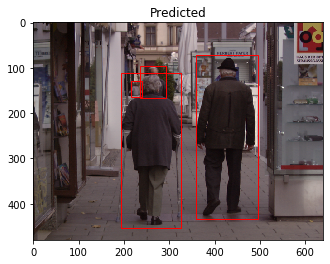

In [10]:
image_id = 10
image = test_set.load_image(image_id)
scaled_image = mold_image(image, cfg)
sample = expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=0)[0]
plot_predicted(image,yhat)

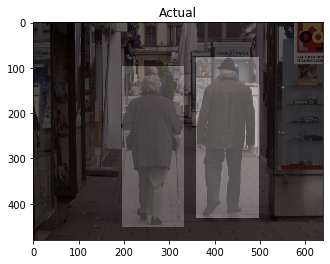

In [12]:
mask, _ = test_set.load_mask(image_id)
plot_actual(image,mask)